In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


import plotly.express as px
import pandas as pd

# TODO Could also try this technique with audio, wonder if blurring would work

In [4]:
from ipywidgets import interact, IntSlider
def show_frames(frames, get_title=None):
    def show_frame(x):
        if get_title:
            plt.title(get_title(x))
        plt.imshow(frames[x])
    return show_frame

In [5]:
def read_frames(n=1000, start=120, skip=15):
    "`skip`: how many to skip between additions"
    i = 0
    frames = []
    cap = cv2.VideoCapture('cache/Joe Rogan Experience #1366 - Richard Dawkins-_bN4spt3744.mp4')

    while i < start: 
        cap.read()
        i += 1

    while len(frames) < n:
        ret, frame = cap.read()
        frames.append(frame)

        for i in range(skip): cap.read()

    cap.release()

    return frames

In [6]:
cap = cv2.VideoCapture('cache/Joe Rogan Experience #1366 - Richard Dawkins-_bN4spt3744.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

In [7]:
### Transforms
def blur(frames, size):
    def b(x): return cv2.GaussianBlur(x, size, cv2.BORDER_DEFAULT)
    return [b(f) for f in frames]

In [8]:
frames = read_frames(1000, start=2000, skip=round(fps/2))

In [9]:
# blurred = blur(frames, (13, 13))

In [10]:
interact(show_frames(frames), x=IntSlider(min=0, max=len(frames) - 1))

interactive(children=(IntSlider(value=0, description='x', max=999), Output()), _dom_classes=('widget-interact'…

<function __main__.show_frames.<locals>.show_frame(x)>

In [11]:
interact(show_frames(blurred), x=IntSlider(value=1262, min=0, max=len(frames) - 1))

NameError: name 'blurred' is not defined

In [12]:
def get_averages(frames):
    averages = []
    for i, frame in enumerate(frames[1:]):
        avg = np.mean([frame, frames[i]])
        averages.append(avg)
    return np.array(averages)

In [13]:
normal_averages = get_averages(frames)

print("----Averages, normal----")
print(len(frames), len(normal_averages))
print("Uniques:", np.unique([int(avg) for avg in normal_averages]))
print(normal_averages[:10], end='\n\n')

# blurred_averages = get_averages(blurred)

# print("----Averages, blurred----")
# print(len(blurred), len(blurred_averages))
# print("Uniques:", np.unique([int(avg) for avg in blurred_averages]))
# print(blurred_averages[:10])

----Averages, normal----
1000 999
Uniques: [25 26 27 28 47 48 52 68 69 70 78 79]
[25.85976056 25.98217159 26.33660807 26.38528501 26.18058015 26.13867549
 26.10379196 26.08905961 26.03449002 25.978023  ]



In [14]:
df = pd.DataFrame({
  'x': normal_averages,
#   'x': blurred_averages,
  'n': range(len(frames) - 1),
})

fig = px.scatter(df, x='x', color='n')
fig.show()

In [106]:
get_title = lambda x: f"{int(normal_averages[x])} average"
interact(show_frames(frames, get_title), x=IntSlider(min=0, value=471, max=len(normal_averages) - 1))

interactive(children=(IntSlider(value=471, description='x', max=998), Output()), _dom_classes=('widget-interac…

<function __main__.show_frames.<locals>.show_frame(x)>

In [179]:
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans, DBSCAN
from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelextrema

def kde_cluster(Xdf, kernel="gaussian", bandwidth=10, plot=False):
    """
    Uses KDE to create clusters out of word vecs
    """
    X = np.array(Xdf['x'])
    X = X.reshape(-1, 1)

    # TODO There is probably bias at the boundaries, should mirror X
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(X)
    s = np.linspace(0, np.max(X)*1.5)
    e = kde.score_samples(s.reshape(-1, 1))

    # Reshape back to a 1 by N array
    X = X.reshape(1, -1)

    minima = argrelextrema(e, np.less)[0]
    # Use the linspace to convert back into word indexes
    minima = [s[m] for m in minima]
    # (0, minima 1), (minima 1, minima 2), ... (minima n-1, minima n), (minima n, end)
    minima_pairs = list(zip(np.insert(minima, 0, 0), np.append(minima, s[-1])))

    clusters = [
      np.unique(X[np.logical_and(X >= m1, X < m2)]) for m1, m2 in minima_pairs
    ]

    if plot:
      plt.plot(s, e)
      plt.show()
      print(f"Number of clusters: {len(clusters)}")
      for c in clusters:
          print("\t", len(c), np.unique([int(x) for x in c]))

    return clusters

# Store frame numbers in the clusters instead of the average of the last frame
def frame_idxs_clusters(aavg_clusters, df):
  df_2 = df_avg.copy()
  df_2['cluster'] = np.full_like((len(averages)), -1)

  # clusters = []
  for i, c in enumerate(avg_clusters):
      # clusters.append([])
      for j, frame in enumerate(frames[:-1]):
          if normal_averages[j] >= np.min(c) and normal_averages[j] <= np.max(c):
              clusters[i].append(j)
              df_2['cluster'][j] = i
              continue
  
  return df_2

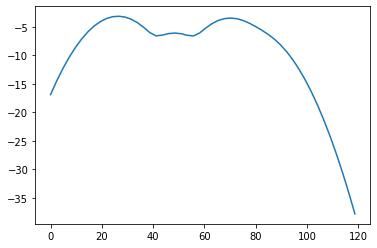

Number of clusters: 3
	 545 [25 26 27 28]
	 29 [47 48 52]
	 425 [68 69 70 78 79]


((3,), 17)

In [98]:
# TODO How to estimate bandwidth for 2d data?
avg_clusters = kde_cluster(df, plot=True, bandwidth=5)
# TODO Actually returns a df now
clusters = frame_idxs_clusters(avg_clusters)

clusters = np.array(clusters)
clusters.shape, clusters[1][0]

In [103]:
def get_title(x):
    return "Cluster " + str([i for i, c in enumerate(clusters) if x in c][0])

interact(show_frames(frames, get_title), x=IntSlider(min=0, value=85, max=len(normal_averages) - 1))

interactive(children=(IntSlider(value=85, description='x', max=998), Output()), _dom_classes=('widget-interact…

<function __main__.show_frames.<locals>.show_frame(x)>

In [137]:
def get_frames(cap, n=1000, start=120, skip=15):
    "`skip`: how many to skip between additions"
    i = 0
    frames = []   
    no_more_frames = False

    while i < start: 
        cap.read()
        i += 1

    while len(frames) < n:
        ret, frame = cap.read()
        
        if not ret:
            no_more_frames = True
            break

        frames.append(frame)
        i += 1

        for _ in range(skip): 
            i += 1
            cap.read()

    return np.array(frames), i, no_more_frames

# Loop over entire video and compute averages for all of the frames
def averages_for_video(filename, window = 2500):
    averages = []    
    total_frames = n = 0
    done = False

    cap = cv2.VideoCapture(filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    while not done:
        frames, total, done = get_frames(cap, window, skip=round(fps/2), start=n*window)
        averages.extend(get_averages(frames))
        
        frames = None
        total_frames += total
        n += 1

        print(f'\r\t{n * window}/{total_frames} frames')

    cap.release()

    return np.array(averages), total_frames

In [140]:
fn = 'cache/Joe Rogan Experience #1366 - Richard Dawkins-_bN4spt3744.mp4'
averages, total_frames = averages_for_video(fn)
np.save(fn + f'{total_frames}.averages', [averages, total_frames])
"total frames", total_frames

	2500/40000 frames
	5000/82500 frames
	7500/110844 frames


('total frames', 110844)

In [164]:
df_avg = pd.DataFrame({ 
    'x': averages,
    'frame_idx': [i/total_frames*total_frames for i in range(len(averages))]
})

In [165]:
fig = px.scatter(df_avg, x='x', color='frame_idx')
fig.show()

In [ ]:
ff = read_frames(n=1000, start=)
interact(show_frames(ff), x=IntSlider(min=0, max=len(frames) - 1))

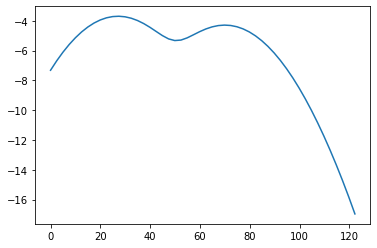

Number of clusters: 2
	 4214 [23 24 25 26 27 28 29 30 36 47 48 49]
	 2237 [49 50 52 53 68 69 70 71 72 73 74 75 76 78 79 81]


In [180]:
df_2 = frame_idxs_clusters(kde_cluster(df_avg, plot=True), df_avg)

In [182]:
fig = px.scatter(df_2, x='x', color='cluster')
fig.show()